In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from utilities import clean_arabic_tweet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np
from nltk import ngrams
from sklearn.metrics import classification_report, f1_score
from plot_keras_history import plot_history


In [2]:
pd.set_option('display.max_colwidth', -1)

In [6]:
train_data_path = './cleaned_data/cleaned_train_data_for_subtask1.csv'
test_data_path = './cleaned_data/cleaned_test_data_for_subtask1.csv'

In [7]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

<AxesSubplot:>

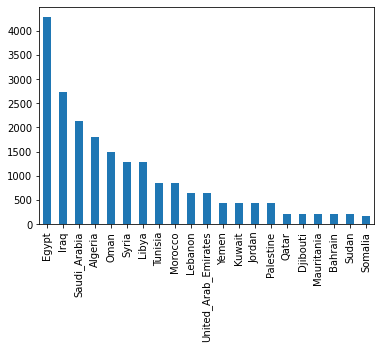

In [8]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

In [9]:
classes_names = train_data['#3_country_label'].unique().tolist()
classes_map={}
for i,class_name in enumerate(classes_names):
    classes_map[class_name]=i

In [11]:
def find_class_id_from_name(class_name):
    return classes_map[class_name]

In [12]:
train_data['classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['classes_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

# train_data['#2_tweet_clean']=train_data['#2_tweet_clean'].apply(clean_arabic_tweet)
# test_data['#2_tweet_clean']=test_data['#2_tweet_clean'].apply(clean_arabic_tweet)

In [13]:
train_x = train_data['#2_tweet_clean'].tolist()
train_y = train_data['classes_id'].tolist()

test_x = test_data['#2_tweet_clean'].tolist()
test_y = test_data['classes_id'].tolist()

In [15]:
train_data.head(50)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean,classes_id
0,TRAIN_0,حاجة حلوة اكيد,Egypt,حاجة حلوة اكيد,0
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,1
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,ابشر طال عمرك,2
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا. #قطع_العلاقات_مع_قطر #موريتانيا_مع_قطر,Mauritania,منطق انا والغريب علي ابن عمي وانا والغريب وابن عمي علي اخويا قطع العلاقات مع قطر موريتانيا مع قطر,3
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,شهرين وتروح والباقي غير صيف ملينا,4
5,TRAIN_5,يابنتى والله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا.,Syria,يابنتى واله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا,5
6,TRAIN_6,نفس الوقت بأكد على صاحبتي ان اي هدف هتحطه وتخططله هيبوظ والأفضل التشاؤم واننا نتوقع الأسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,Egypt,نفس الوقت باكد على صاحبتي ان اي هدف هتحطه وتخطله هيبوظ والافضل التشاؤم وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,0
7,TRAIN_7,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك URL …,Egypt,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,0
8,TRAIN_8,ما يله دخل !,Oman,ما يله دخل,6
9,TRAIN_9,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,Iraq,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,1


## tokanize the trainset for creating the embedding layer

In [16]:
vocab_size = 60000
embedding_dim = 64
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [17]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=60000)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_x)

## padding/truncating tweets to be the same length

In [18]:
training_sequences = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_x)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## convert labels to categorical from class id to categorical vector

In [19]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [20]:
training_padded = np.array(training_padded)
training_labels = train_y
testing_padded = np.array(testing_padded)
testing_labels = test_y

## create the lstm Model

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3,recurrent_dropout=0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(21, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 64)            3840000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 21)               

## training 

In [33]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),batch_size=32, verbose=1)

Epoch 1/10
657/657 [==============================] - 162s 242ms/step - loss: 2.6952 - accuracy: 0.1964 - val_loss: 2.5949 - val_accuracy: 0.2172
Epoch 2/10
657/657 [==============================] - 169s 258ms/step - loss: 2.5597 - accuracy: 0.2061 - val_loss: 2.5948 - val_accuracy: 0.1888
Epoch 3/10
657/657 [==============================] - 151s 229ms/step - loss: 2.5149 - accuracy: 0.2068 - val_loss: 2.6163 - val_accuracy: 0.2168
Epoch 4/10
657/657 [==============================] - 153s 233ms/step - loss: 2.4153 - accuracy: 0.2436 - val_loss: 2.5597 - val_accuracy: 0.2410
Epoch 5/10
657/657 [==============================] - 173s 263ms/step - loss: 2.1368 - accuracy: 0.3271 - val_loss: 2.6139 - val_accuracy: 0.2710
Epoch 6/10
657/657 [==============================] - 166s 253ms/step - loss: 1.8531 - accuracy: 0.4182 - val_loss: 2.7145 - val_accuracy: 0.2720
Epoch 7/10
657/657 [==============================] - 170s 258ms/step - loss: 1.5919 - accuracy: 0.4942 - val_loss: 3.1292 -

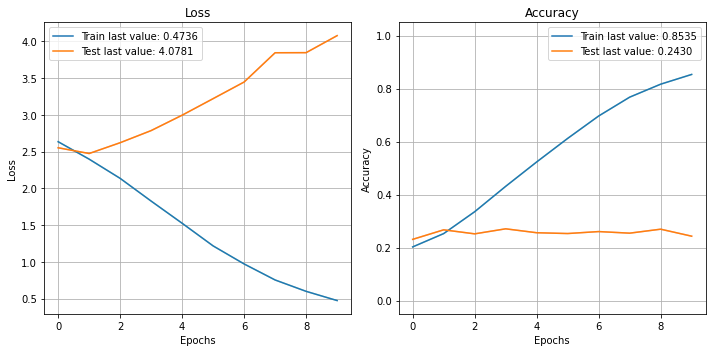

In [24]:
plot_history(history.history)
plt.show()

## evaluation

In [25]:
result = np.argmax(model.predict(testing_padded), axis=-1)

In [26]:
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))

                      precision    recall  f1-score   support

               Egypt       0.63      0.50      0.55      1041
                Iraq       0.36      0.25      0.30       664
        Saudi_Arabia       0.17      0.33      0.23       520
          Mauritania       0.31      0.08      0.12        53
             Algeria       0.43      0.29      0.34       430
               Syria       0.07      0.05      0.06       278
                Oman       0.14      0.27      0.18       355
             Tunisia       0.28      0.10      0.15       173
             Lebanon       0.07      0.04      0.05       157
             Morocco       0.18      0.04      0.07       207
            Djibouti       0.00      0.00      0.00        27
United_Arab_Emirates       0.06      0.12      0.08       157
              Kuwait       0.04      0.08      0.05       105
               Libya       0.21      0.12      0.15       314
             Bahrain       0.01      0.02      0.01        52
       

In [27]:
print(f1_score(test_data['classes_id'].astype(int).tolist(), result, average='macro'))

0.1235750321075804


## bidirectional Lstm

In [42]:
bi_directional_LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.3, recurrent_dropout = 0.3, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.3, recurrent_dropout = 0.3, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(21, activation='softmax')
])
bi_directional_LSTM_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [43]:
history = bi_directional_LSTM_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),batch_size=32, verbose=1)

Epoch 1/10
657/657 [==============================] - 313s 467ms/step - loss: 2.6752 - accuracy: 0.2003 - val_loss: 2.4769 - val_accuracy: 0.2758
Epoch 2/10
657/657 [==============================] - 332s 506ms/step - loss: 2.4471 - accuracy: 0.2726 - val_loss: 2.4308 - val_accuracy: 0.2880
Epoch 3/10
657/657 [==============================] - 359s 546ms/step - loss: 2.1521 - accuracy: 0.3305 - val_loss: 2.5360 - val_accuracy: 0.2830
Epoch 4/10
657/657 [==============================] - 357s 544ms/step - loss: 1.8577 - accuracy: 0.4092 - val_loss: 2.6341 - val_accuracy: 0.2632
Epoch 5/10
657/657 [==============================] - 303s 461ms/step - loss: 1.5491 - accuracy: 0.5170 - val_loss: 2.8092 - val_accuracy: 0.2780
Epoch 6/10
657/657 [==============================] - 289s 440ms/step - loss: 1.2074 - accuracy: 0.6249 - val_loss: 3.0904 - val_accuracy: 0.2862
Epoch 7/10
657/657 [==============================] - 267s 407ms/step - loss: 0.9812 - accuracy: 0.6989 - val_loss: 3.3702 -

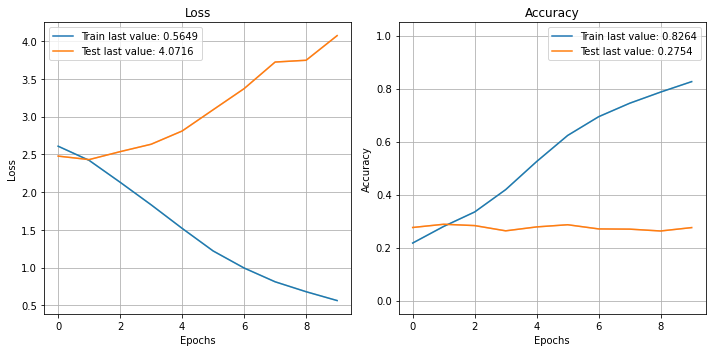

In [44]:
plot_history(history.history)
plt.show()

In [47]:
result = np.argmax(bi_directional_LSTM_model.predict(testing_padded), axis=-1)

In [48]:
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))

                      precision    recall  f1-score   support

               Egypt       0.56      0.63      0.60      1041
                Iraq       0.45      0.28      0.34       664
        Saudi_Arabia       0.18      0.30      0.22       520
          Mauritania       0.10      0.04      0.05        53
             Algeria       0.37      0.33      0.35       430
               Syria       0.09      0.07      0.08       278
                Oman       0.17      0.19      0.18       355
             Tunisia       0.13      0.08      0.10       173
             Lebanon       0.09      0.04      0.05       157
             Morocco       0.09      0.07      0.08       207
            Djibouti       0.00      0.00      0.00        27
United_Arab_Emirates       0.08      0.10      0.09       157
              Kuwait       0.03      0.02      0.02       105
               Libya       0.18      0.26      0.21       314
             Bahrain       0.04      0.04      0.04        52
       